In [1]:
%%capture

!pip install pafy youtube-dl moviepy

In [2]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping

  if event.key is 'enter':



In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [4]:
# Download data
%%capture

!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

!unrar x UCF50.rar

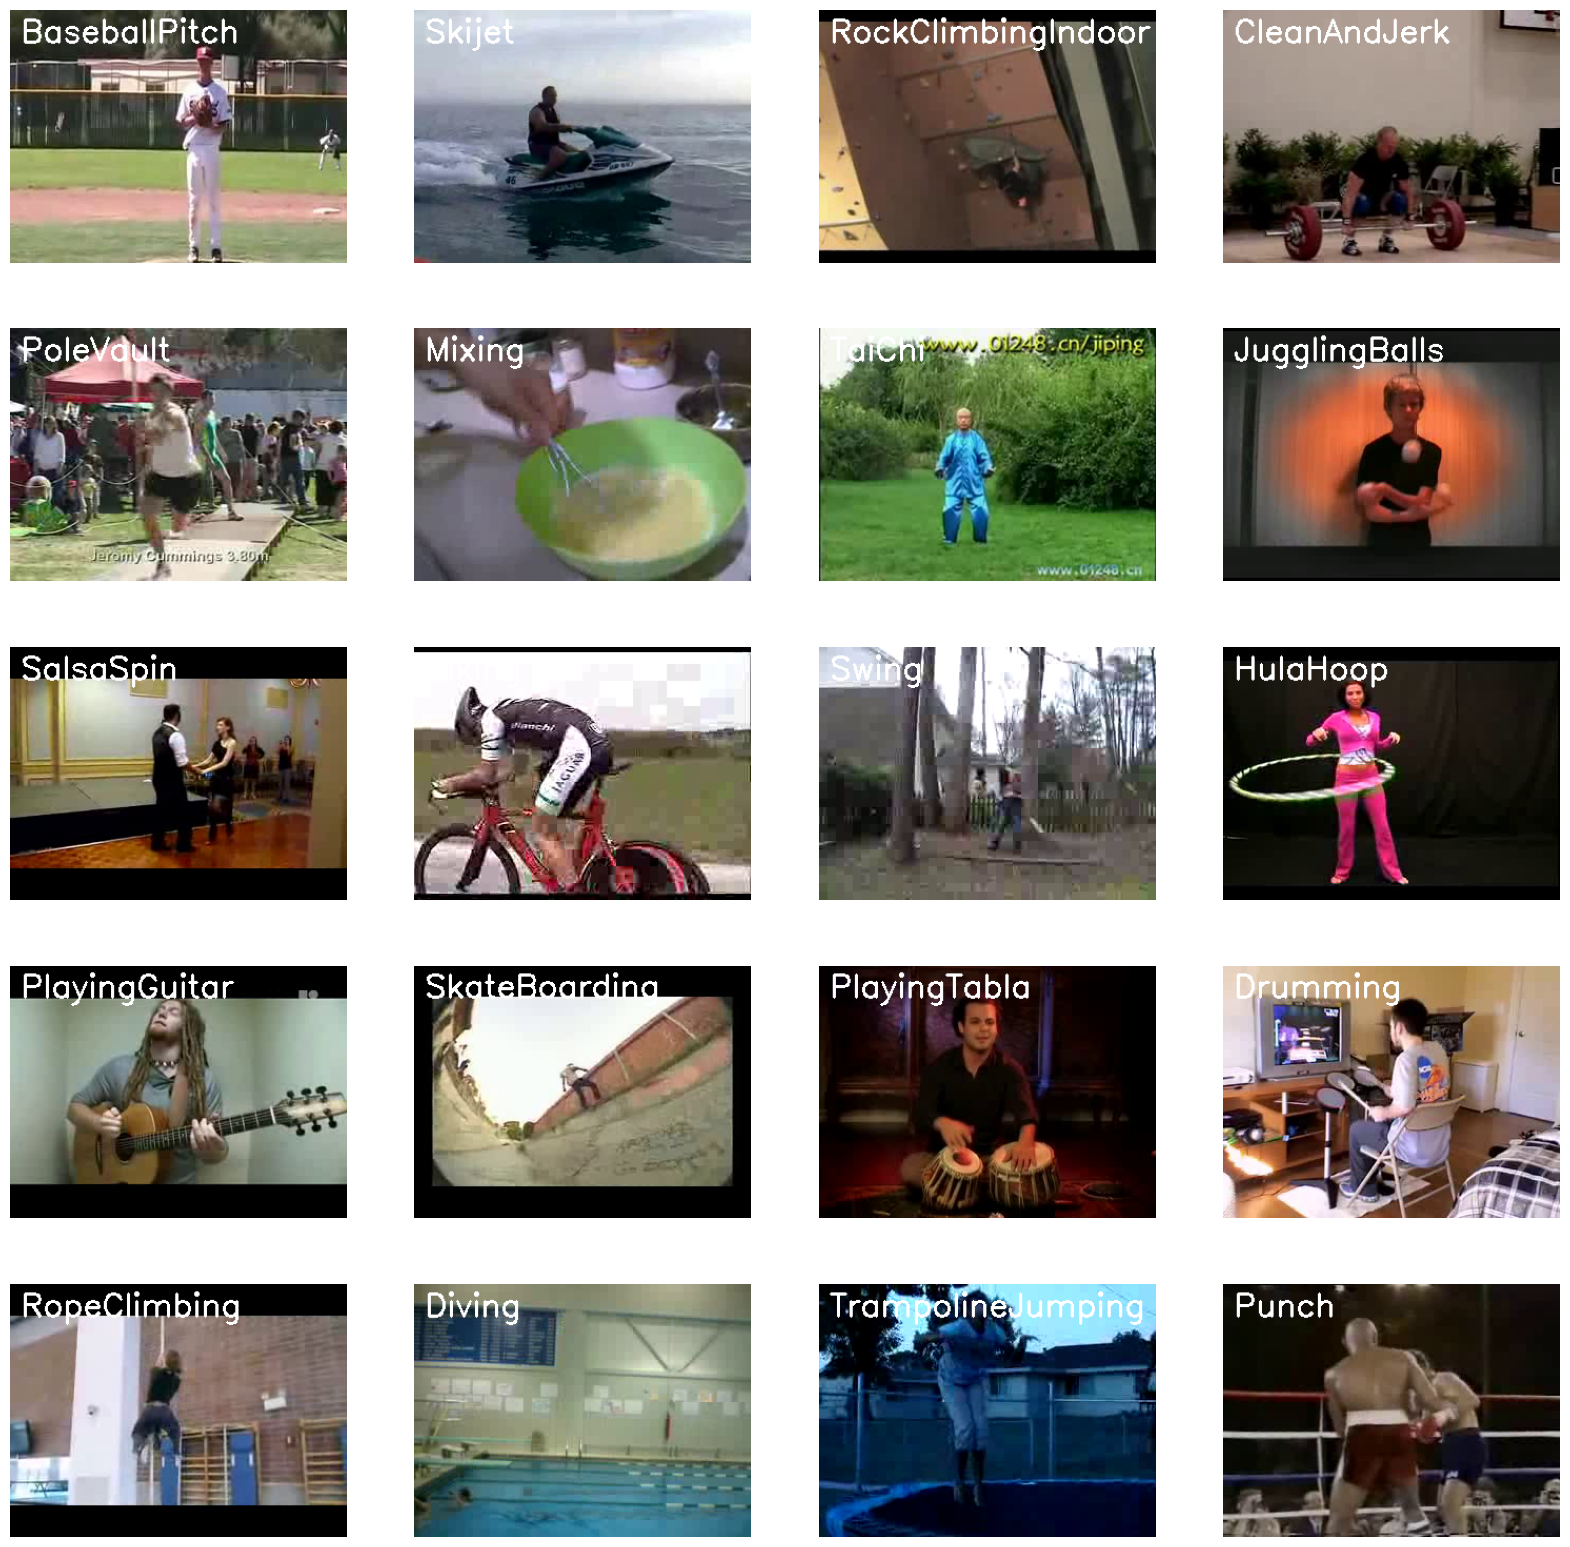

In [5]:
# Visualize data
plt.figure(figsize=(20, 20))

all_classes = os.listdir('UCF50')

random_range = random.sample(range(len(all_classes)), 20)

for counter, random_idx in enumerate(random_range):
    selected_class = all_classes[random_idx]

    video_files_in_class = os.listdir('UCF50/' + selected_class)
    selected_video = random.choice(video_files_in_class)

    video_reader = cv2.VideoCapture('UCF50/' + selected_class + '/' + selected_video)

    _, frame = video_reader.read()

    video_reader.release()

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.subplot(5, 4, counter + 1)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [6]:
# Preprocess data
IMG_HEIGHT, IMG_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
dir = "UCF50"
CLASSES_LIST = ["WalkingWithDog", "PlayingGuitar", "Swing", "HorseRiding"]

In [7]:
def extract_frame(video_path):
  frames_list = []
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    success, frame = video_reader.read()
    if not success:
      break
    resized_frame = cv2.resize(frame, (IMG_HEIGHT, IMG_WIDTH))

    norm_frame = resized_frame / 255
    frames_list.append(norm_frame)

  video_reader.release()
  return frames_list

In [8]:
# Dataset Creation
def create_dataset():
  features = []
  labels = []
  video_paths = []
  for class_index, class_name in enumerate(CLASSES_LIST):
    print(f'Extracting Data of class: {class_name}')
    files_list = os.listdir(os.path.join(dir, class_name))

    for file_name in files_list:
      video_file_path = os.path.join(dir, class_name, file_name)
      frames_list = extract_frame(video_file_path)

      if len(frames_list) == SEQUENCE_LENGTH:
        features.append(frames_list)
        labels.append(class_index)
        video_paths.append(video_file_path)
  features = np.asarray(features)
  labels = np.array(labels)
  return features, labels, video_paths

In [9]:
features, labels, video_paths = create_dataset()
one_hot_encoded_labels = to_categorical(labels)

Extracting Data of class: WalkingWithDog
Extracting Data of class: PlayingGuitar
Extracting Data of class: Swing
Extracting Data of class: HorseRiding


In [10]:
f_train, f_test, l_train, l_test = train_test_split(features, one_hot_encoded_labels, test_size=0.2, shuffle=True, random_state=SEED)

In [11]:
# ConvLSTM Implementation
def create_convlstm_model():
  model = Sequential()
  model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', data_format='channels_last',
                       recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3)))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format='channels_last',
                       recurrent_dropout=0.2, return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh', data_format='channels_last',
                       recurrent_dropout=0.2, return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format='channels_last',
                       recurrent_dropout=0.2, return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(Flatten())
  model.add(Dense(len(CLASSES_LIST), activation='softmax'))

  model.summary()
  return model

In [12]:
convlstm_model = create_convlstm_model()

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │          11,524 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,524 (173.92 KB)

 Trainable params: 44,524 (173.92 KB)

 Non-trainable params: 0 (0.00 B)

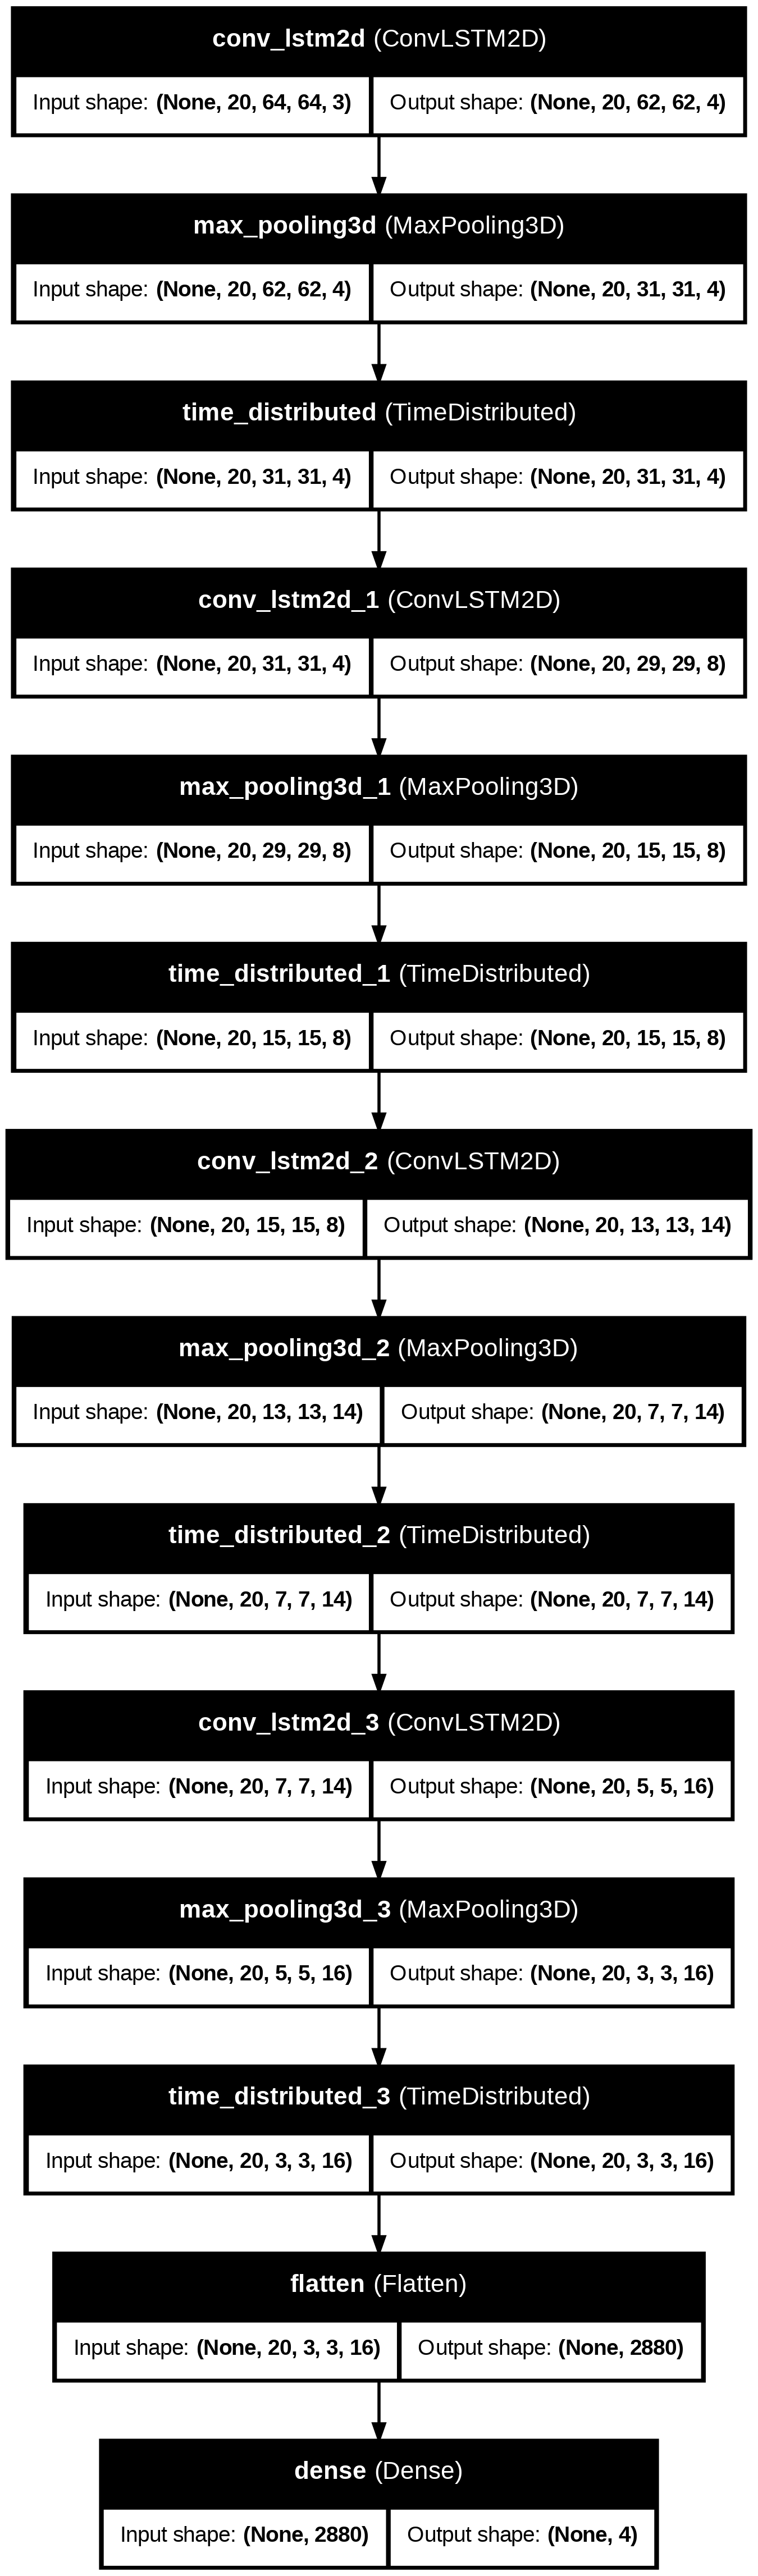

In [13]:
plot_model(convlstm_model, to_file='convlstm_model_structure_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
# Compile and train
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

convlstm_model_training_history = convlstm_model.fit(x=f_train, y=l_train, epochs=50, batch_size=4,
                                                      shuffle=True, validation_split=0.2, callbacks=[early_stop])

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 57s 353ms/step - accuracy: 0.2592 - loss: 1.3875 - val_accuracy: 0.4747 - val_loss: 1.2672
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 35s 355ms/step - accuracy: 0.5100 - loss: 1.1884 - val_accuracy: 0.4747 - val_loss: 1.1123
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 36s 364ms/step - accuracy: 0.5643 - loss: 0.9900 - val_accuracy: 0.6364 - val_loss: 0.8127
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 40s 349ms/step - accuracy: 0.6314 - loss: 0.8360 - val_accuracy: 0.6768 - val_loss: 0.7586
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 362ms/step - accuracy: 0.6994 - loss: 0.7537 - val_accuracy: 0.6566 - val_loss: 0.6482
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 383ms/step - accuracy: 0.7332 - loss: 0.6372 - val_accuracy: 0.7172 - val_loss: 0.6353
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 37s 372ms/step - accuracy: 0.7822 - loss: 0.5549 - val_accuracy: 0.7475 - val_loss: 0.5845
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 345ms/step - accuracy: 0.7986 - loss: 0.5322 - val_accu

In [15]:
# Evaluating
model_evaluation_history = convlstm_model.evaluate(f_test, l_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7508 - loss: 0.6461


In [16]:
# Save model
convlstm_model.save('convlstm_model.h5')

In [17]:
# Plotting
def plot_metric(model_training_history, metric_name_1, metric_name_2, plotname):
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]
  epochs = range(len(metric_value_1))
  plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
  plt.plot(epochs, metric_value_2, 'green', label=metric_name_2)
  plt.title(str(plotname))
  plt.legend()

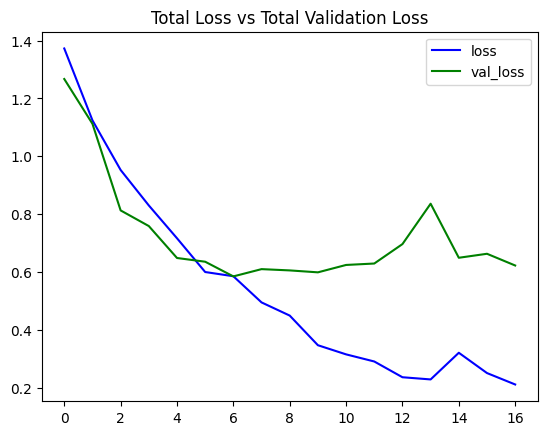

In [18]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [20]:
def LRCN_model():
  model = Sequential()

  model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                              input_shape=(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3)))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  # model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation='softmax'))

  model.summary()
  return model

In [21]:
LRCN_MODEL = LRCN_model()

  super().__init__(**kwargs)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_4 (TimeDistributed) │ (None, 20, 64, 64, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 20, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 20, 16, 16, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 20, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 20, 4, 4, 64)        │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 20, 2, 2, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 20, 2, 2, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 20, 2, 2, 64)        │          36,928 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, 20, 1, 1, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 20, 64)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,060 (285.39 KB)

 Trainable params: 73,060 (285.39 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
early_stop_new = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

LRCN_MODEL.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

LRCN_model_training_history = LRCN_MODEL.fit(x=f_train, y=l_train, epochs=50, batch_size=4,
                                          shuffle=True, validation_split=0.2, callbacks=[early_stop_new])

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - accuracy: 0.2317 - loss: 1.4019 - val_accuracy: 0.3131 - val_loss: 1.3696
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.3007 - loss: 1.3674 - val_accuracy: 0.3838 - val_loss: 1.3233
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.4290 - loss: 1.2856 - val_accuracy: 0.5152 - val_loss: 1.1188
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.4806 - loss: 1.0910 - val_accuracy: 0.3737 - val_loss: 1.1530
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4410 - loss: 1.0728 - val_accuracy: 0.6667 - val_loss: 0.8723
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6171 - loss: 0.8964 - val_accuracy: 0.6869 - val_loss: 0.7937
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.6710 - loss: 0.8164 - val_accuracy: 0.6970 - val_loss: 0.8093
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6572 - loss: 0.8034 - val_accuracy: 0.6768 -

In [23]:
model_evaluation_history = LRCN_MODEL.evaluate(f_test, l_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8989 - loss: 0.3281


In [25]:
LRCN_MODEL.save('LRCN_model.h5')

In [26]:
# Test on YT video
def download_yt_video(yt_url, output_dir):
  video = pafy.new(yt_url)
  best = video.getbest(preftype='mp4')
  title = video.title
  filename = f'{title}.mp4'
  output_path = os.path.join(output_dir, filename)
  best.download(filepath=output_path, quiet=True)
  return title